In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql.functions import countDistinct

In [2]:
#reading in sticker type data
feature_data = sqlContext.read.parquet("gs://ds-url-catag/Stickers/stick_statistics/sticker_download/derived_features/")

In [3]:
#convert pyspark to pandas dataframe
import pandas as pd
feature_data_df  = feature_data.toPandas()
#checking size of dataframe
print 'Size of the dataframe: {}'.format(feature_data_df.shape)

Size of the dataframe: (2422112, 9)


In [4]:
#logarithmic transformation of two different variables
import numpy as np
feature_data_df['log_noofdays']=np.log10(1+feature_data_df.numofdays)
feature_data_df['log_avg_con_days']=np.log10(1+feature_data_df.avg_con_days)
feature_data_df['log_sticker_packs_download']=np.log10(1+feature_data_df.sticker_packs_download)
feature_data_df['log_distinct_sticker_packs_download']=np.log10(1+feature_data_df.distinct_sticker_packs_download)
feature_data_df['log_sum_paid']=np.log10(1+feature_data_df.sum_paid)
feature_data_df['log_sum_free']=np.log10(1+feature_data_df.sum_free)
feature_data_df['log_sum_subs']=np.log10(1+feature_data_df.sum_subs)
feature_data_df['log_sum_discont']=np.log10(1+feature_data_df.sum_discont)


In [5]:
#convert the values into an array for the purpose of PCA
import numpy as np
rndperm = np.random.permutation(feature_data_df.shape[0])

In [6]:
#computing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_data_df[['log_noofdays','log_avg_con_days','log_sticker_packs_download','log_distinct_sticker_packs_download','log_sum_paid','log_sum_free','log_sum_subs','log_sum_discont']].values)

feature_data_df['pca-one'] = pca_result[:,0]
feature_data_df['pca-two'] = pca_result[:,1] 
feature_data_df['pca-three'] = pca_result[:,2]


print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)


Explained variation per principal component: [0.84976502 0.06767649 0.03883627]


In [7]:
from ggplot import *
chart = ggplot(feature_data_df.loc[rndperm[:5000],:], aes(x='pca-one', y='pca-two') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components")
chart

/usr/local/lib/python2.7/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python2.7/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<ggplot: (8749090372325)>

In [8]:
#clustering using Kmeans -PCA
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
model = kmeans.fit(feature_data_df[['pca-one','pca-two']])
y_kmeans = kmeans.predict(feature_data_df[['pca-one','pca-two']])

In [9]:
feature_data_df['clusters'] = kmeans.labels_

In [10]:
feature_data_df.columns

Index([u'user_id_n', u'numofdays', u'avg_con_days', u'sticker_packs_download',
       u'distinct_sticker_packs_download', u'sum_paid', u'sum_free',
       u'sum_subs', u'sum_discont', u'log_noofdays', u'log_avg_con_days',
       u'log_sticker_packs_download', u'log_distinct_sticker_packs_download',
       u'log_sum_paid', u'log_sum_free', u'log_sum_subs', u'log_sum_discont',
       u'pca-one', u'pca-two', u'pca-three', u'clusters'],
      dtype='object')

In [11]:
new_df = feature_data_df.as_matrix(columns=feature_data_df.columns[17:19])

In [12]:
new_df

array([[ 0.3274812 , -0.33973494],
       [ 0.09493548, -0.04663523],
       [-0.38110301, -0.0036619 ],
       ...,
       [-0.174752  , -0.07002097],
       [ 0.59914169, -0.12282575],
       [-0.2968415 , -0.16701857]])

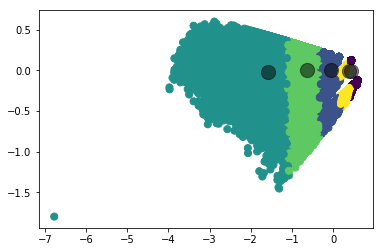

In [13]:
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_
plt.scatter(new_df[:, 0], new_df[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [14]:
transformed = model.transform(feature_data_df[['pca-one','pca-two']])

In [15]:
transformed.shape

(2422112, 5)

In [16]:
print list(transformed)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

